# KNN Multi-Class (Mask, No Mask, Incorrect Mask)

Things to consider:

- [ ] Curse of Dimensionality (4096 space)
- [ ] Hyperparameter Tuning
    - [X] Distance Metrics
    - [X] KNN, K
    - [ ] Uniform V. Weighted
- [X] More Performance Metrics
- [ ] Overfitting 

## Imports

In [1]:
# import packages
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from imutils import paths

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt # to plot inage, graph

import os
import PIL
import cv2
import pickle
import time # for computation time assessment
%matplotlib inline

## Get Feature and Target Extraction

### Pickle Dataset

In [2]:
pickle_in = open("X.pickle", "rb")
X = pickle.load(pickle_in)
pickle_in = open("y.pickle", "rb")
y = pickle.load(pickle_in)
pickle_in = open("data.pickle", "rb")
data = pickle.load(pickle_in) # Data Matrix will serve as X

### Dataset Classification Distribution

In [3]:
print('# of Samples:', len(y))
print('# of Without A Mask:', (y == 0).sum())
print('# of Incorrectly Worn Mask:', (y == 1).sum())
print('# of With A Mask:', (y == 2).sum())

# How much memory X features takes up
print("\n[INFO] image matrix: {:.2f}MB".format(
    X.nbytes / (1024 * 1000.0)))

# How much memory y target takes up
print("[INFO] target matrix: {:.2f}MB".format(
    y.nbytes / (1024 * 1000.0)))

# How much memory data features takes up
print("[INFO] data/features matrix: {:.2f}MB".format(
    data.nbytes / (1024 * 1000.0)))

# Data numpy to dataframe
cols = [] # Get Column Names

for i in range(0, len(data[0])):
    cols.append("P" + str(i))
    
numpy_data = data
X = pd.DataFrame(data=numpy_data, columns=[cols])
print(X.head())

y = pd.DataFrame(data=y, columns=["Mask_Target"])
print(y.head())

# of Samples: 17687
# of Without A Mask: 5909
# of Incorrectly Worn Mask: 5895
# of With A Mask: 5883

[INFO] image matrix: 70.75MB
[INFO] target matrix: 0.14MB
[INFO] data/features matrix: 70.75MB
    P0   P1   P2   P3   P4   P5   P6   P7   P8   P9  ... P4086 P4087 P4088  \
0   20   21   19   22   29   31   37   51   54   37  ...   132   131   106   
1  127  127  125  126   87   69   34   30   33   37  ...   141   156   156   
2   48   43   37   34   34   40   49   83  100  106  ...    79    58    41   
3  184   91   63   25   14   17   15   35   44   41  ...    84    86    53   
4  111  125  126   97  109  140  168  185  166   91  ...   138    61    27   

  P4089 P4090 P4091 P4092 P4093 P4094 P4095  
0   158   125    43    24    21    21    34  
1   149   150   149   145   125   115   103  
2    21    14    19    22    23    20    21  
3    17    13    13    14    11    13    15  
4    35    30    38    34    45    54    48  

[5 rows x 4096 columns]
   Mask_Target
0            0
1 

In [4]:
# Shape
print('\nImage Data Shape:', X.shape)
print('Image Data Shape Features:', data.shape)
print('Image Data Shape Target:', y.shape)



Image Data Shape: (17687, 4096)
Image Data Shape Features: (17687, 4096)
Image Data Shape Target: (17687, 1)


### Split Train + Test, random_state

In [5]:
# Split our data into testing and training.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=45)

# Print the length and width of our testing data.
print('Length of our Training data: ',len(X_train), '\nLength of our Testing data: ',len(X_test))

Length of our Training data:  14149 
Length of our Testing data:  3538


## KNN No Hyperparameter Tuning

In [6]:
# since its a multi-class prediction, in order to prevent error we need some library
from sklearn.multiclass import OneVsRestClassifier

### Build and train KNN model

In [7]:
# Initialize KNN model
knn = OneVsRestClassifier(KNeighborsClassifier())

# Use training data to fit KNN model
knn.fit(X_train, y_train)

OneVsRestClassifier(estimator=KNeighborsClassifier())

In [8]:
# make prediction on entire test data
%time
predictions = knn.predict(X_test)

CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 4.29 µs


In [9]:
pickle_out = open("predictions_no_hyperparameter_tuning.pickle", "wb")
pickle.dump(predictions, pickle_out)
pickle_out.close()

## Performance Metrics for No Hyperparameter Tuning

In [10]:
import seaborn as sns # for confusion matrix
from sklearn.metrics import accuracy_score, confusion_matrix,precision_score, recall_score, f1_score

#### Accuracy

In [11]:
%%time
print('KNN Accuracy: %.3f' % accuracy_score(y_test,predictions))
# No Hypertuning: 76.7% Accuracy

CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 4.77 µs
KNN Accuracy: 0.767


#### Confusion Matrix

Text(0.5, 1.0, 'Accuracy Score: 0.8275862068965517')

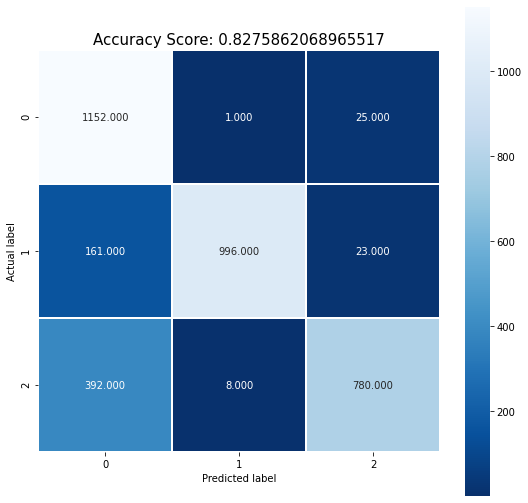

In [50]:
# Calculate Confusion Matrix
cm = confusion_matrix(y_test,predictions)

plt.figure(figsize=(9,9))
# Heatmap visualization of accuracy
sns.heatmap(cm,annot=True, fmt='.3f', linewidths=.5, square=True,cmap='Blues_r')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
all_sample_title = 'Accuracy Score: {0}'.format(accuracy_score(y_test,predictions))
plt.title(all_sample_title,size=15)

#### Precision

In [13]:
%%time
print('KNN Precision: %.3f' % precision_score(y_test,predictions, average='micro'))
# No Hypertuning: 76.7% Precision

CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 4.05 µs
KNN Precision: 0.767


#### Recall

In [14]:
%%time
print('KNN Recall: %.3f' % recall_score(y_test,predictions, average='micro'))
# No Hypertuning: 76.7% Recall

CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 4.29 µs
KNN Recall: 0.767


#### F1 Score

In [15]:
%%time
print('KNN F1 Score: %.3f' % f1_score(y_test,predictions, average='micro'))
# No Hypertuning: 76.7% F1 Score

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 3.1 µs
KNN F1 Score: 0.767


## KNN Hyperparameter Tuning

In [39]:
from sklearn.model_selection import cross_val_score

# #create a new KNN model
# knn_cv = OneVsRestClassifier(KNeighborsClassifier(n_neighbors=3))

# #train model with cv of 5 
# cv_scores = cross_val_score(knn_cv, X, y, cv=5)

# #print each cv score (accuracy) and average them
# print(cv_scores)
# print("cv_scores mean:{}" .format(np.mean(cv_scores)))

### GridSearch for Hyperparameter Tuning

In [36]:
from sklearn.model_selection import GridSearchCV

#create new a knn model
knn2 = KNeighborsClassifier()

#create a dictionary of all values we want to test for n_neighbors
param_grid = {'n_neighbors': [5, 10, 25, 50, 100], 'metric': ['euclidean', 'manhattan', 'minkowski']}

#use gridsearch to test all values for n_neighbors
knn_gscv = GridSearchCV(knn2, param_grid, scoring='f1_micro', cv=5, verbose=3, n_jobs=-1)

In [38]:
#fit model to data
# ~5 hours to compute
knn_gscv.fit(X_train, y_train.values.ravel())

Fitting 5 folds for each of 15 candidates, totalling 75 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed: 13.7min
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed: 62.8min finished


GridSearchCV(cv=5, estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'metric': ['euclidean', 'manhattan', 'minkowski'],
                         'n_neighbors': [5, 10, 25, 50, 100]},
             scoring='f1_micro', verbose=3)

In [45]:
#check top performing n_neighbors value
best_params_ = knn_gscv.best_params_

In [46]:
#check mean score for the top performing value of n_neighbors
knn_gscv.best_score_

0.820198974028456

In [47]:
pickle_out = open("predictions_hyperparameter_gscv.pickle", "wb")
pickle.dump(knn_gscv, pickle_out)
pickle_out.close()

pickle_out = open("predictions_hyperparameter_cv.pickle", "wb")
pickle.dump(knn_cv, pickle_out)
pickle_out.close()

## Test Best Parameters 

In [48]:
# create new a knn model with best params
knn2 = KNeighborsClassifier(**best_params_)

#fit model to data
%time
knn2.fit(X_train, y_train.values.ravel())

# make prediction on entire test data
%time
predictions = knn2.predict(X_test)

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 6.91 µs
CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 4.05 µs


### Performance Metrics on Best Params

KNN Precision: 0.828
KNN Recall: 0.828
KNN F1 Score: 0.828


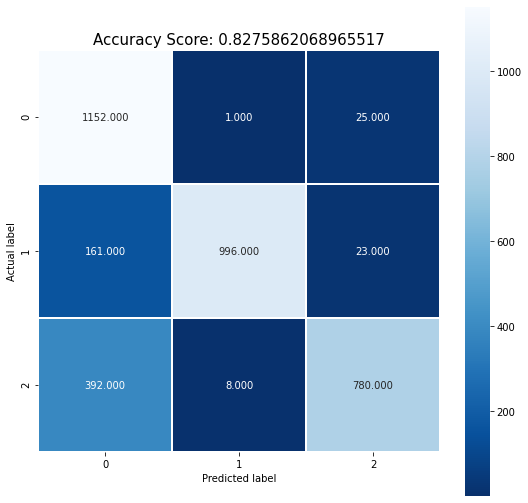

In [51]:
# Calculate Confusion Matrix
cm = confusion_matrix(y_test,predictions)

plt.figure(figsize=(9,9))
# Heatmap visualization of accuracy
sns.heatmap(cm,annot=True, fmt='.3f', linewidths=.5, square=True,cmap='Blues_r')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
all_sample_title = 'Accuracy Score: {0}'.format(accuracy_score(y_test,predictions))
plt.title(all_sample_title,size=15)

print('KNN Precision: %.3f' % precision_score(y_test,predictions, average='micro'))
print('KNN Recall: %.3f' % recall_score(y_test,predictions, average='micro'))
print('KNN F1 Score: %.3f' % f1_score(y_test,predictions, average='micro'))


### Saving & Exporting KNN model for future use

In [49]:
# NAME OF MODEL
filename = 'knn-face-mask-detection-model.pkl'

# EXPORT AND SAVE MODEL 
pickle.dump(knn2, open(filename, 'wb'))